# Introduction
This notebook generates the figures for the paper: *Energy-based Advection Modelling Using Bond Graphs*. This is a tidied and extended version of the 2021 version.

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as disp

## Control toolbox
import control as con
## Bond graph tools
import BondGraphTools as bgt
print('BondGraphTools version', bgt.version)
## Stoichiometric analysis
import stoich as st
## SVG bg representation conversion
import svgBondGraph as sbg
## Modular bond graphs
import modularBondGraph as mbg
## Stoichiometric conversion
import stoichBondGraph as stbg
## Allow reloading of modules
import importlib as imp

## Set quiet=False for verbose output
quiet = True

## Plot parameters
lw = 5

## Optional plotting
Plotting = False
def Savefig(plotname):
    if Plotting:
        plt.savefig(plotname)

Warning - scikit.odes not found. Simulations are disabled.
BondGraphTools version 0.4.6


# Pipe

## Chain of compartments
This is the lumped model of advection considered in Section 3.1. of the paper.
Using the modular extension to BGT, a chain of simple \ch{A <> B} reactions of length $N$ is created.

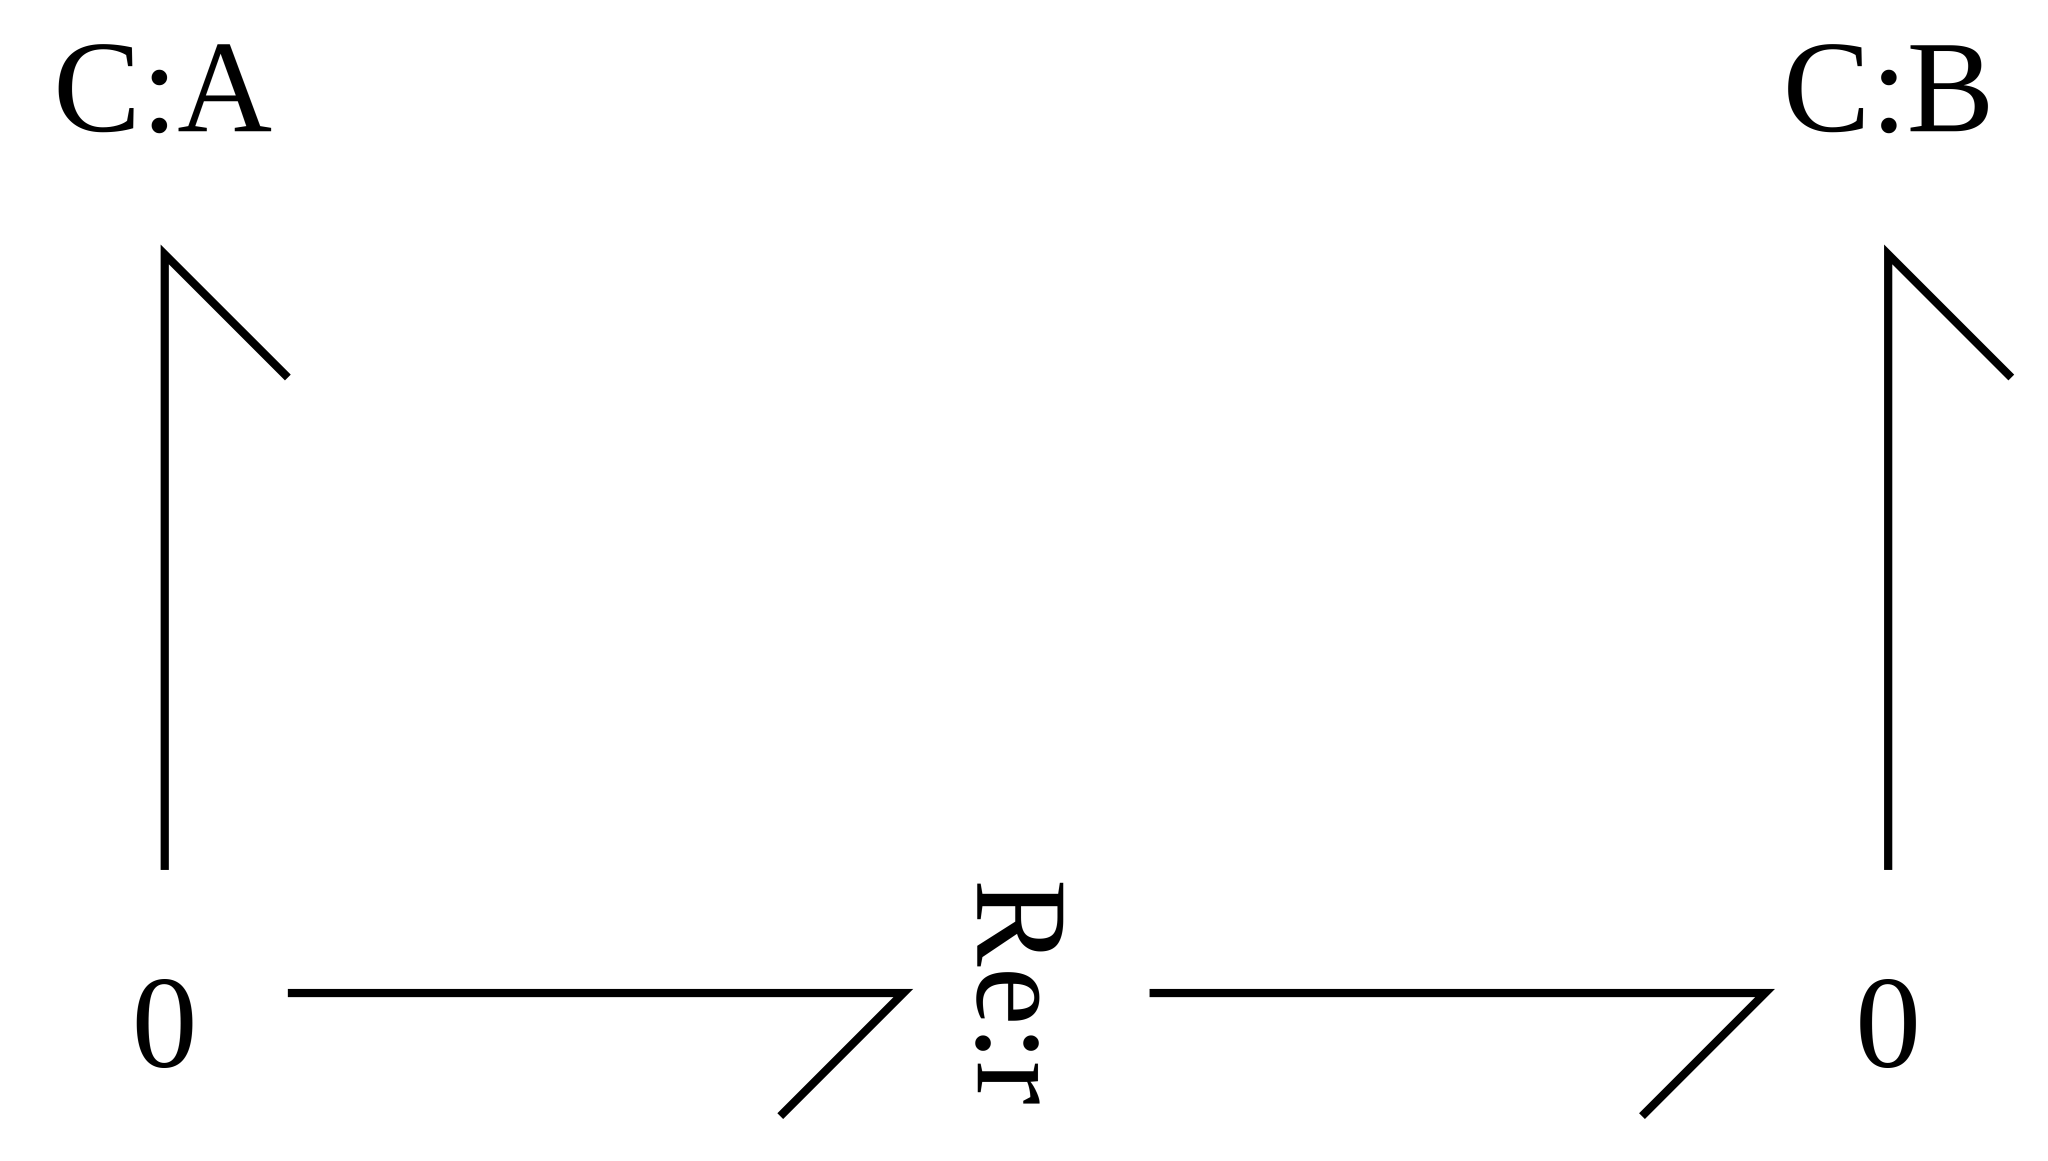

In [2]:
## Simple A <==> B reaction
sbg.model('AB_abg.svg')
import AB_abg
disp.SVG('AB_abg.svg')

In [3]:
s0 = st.stoich(AB_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s0))

<IPython.core.display.Latex object>

In [4]:
chain = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                      N=1,rename_components=False,quiet=False)
ss0 = st.stoich(chain,quiet=quiet)
disp.Latex(st.sprintrl(ss0))

Exposing A and B
Creating ABChain
Creating AB0 from AB within ABChain
Creating A from A within ABChain
Creating jA from 013 within ABChain
Creating B from A within ABChain
Creating jB from 013 within ABChain


<IPython.core.display.Latex object>

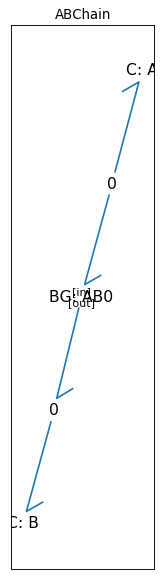

In [5]:
bgt.draw(chain)

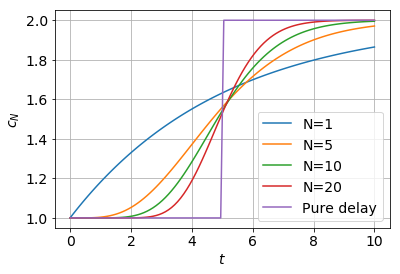

In [6]:
## Vary number of lumps
N_lumps = [1,5,10,20]
#N_lumps = [1]
Q0 = 2
V_p = 10
delay = V_p/Q0

## Time
t = np.linspace(0,2*delay,100)

plt.rcParams.update({'font.size': 14})
    
## Create pipe model Pipe for various numbers of lumps
for N_lump in N_lumps:
    Pipe = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                      N=N_lump+1,rename_components=True,Comps=['R'],quiet=quiet)
    V_i = V_p/N_lump # Volume of lump
    parameter = {}
    UniDir = []
    for i in range(N_lump+1):
        reac = f'r_{i}'
        UniDir.append(reac)
        kap = f'kappa_{reac}'
        parameter[kap] = Q0
        
    s = st.stoich(Pipe,UniDir=UniDir, quiet=quiet)
    sc = st.statify(s,chemostats=['A','B'])
    species = s['species']
    disp.Latex(st.sprintrl(s))
    X0 = np.ones(s['n_X'])
    X0[species.index('A')] = 2
    for i in range(N_lump):
        spec = f'IS{i+1}'
        K = f'K_{spec}'
        parameter[K] = 1/V_i
        X0[species.index(spec)] = V_i

    dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,quiet=quiet)
    r_N = f'r_{N_lump}'
    i_N = species.index(f'IS{N_lump}')
    x_N = dat['X'][:,i_N]
    
    
    plt.plot(t,x_N/V_i,label=f'N={N_lump}')

## Pure delay
y_del = 1+np.heaviside(t-delay,1)
plt.plot(t,y_del,label='Pure delay')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$c_N$')
Savefig('Figs/Pipe.pdf')

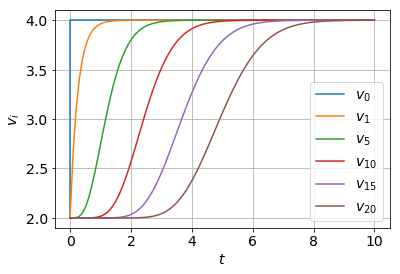

<Figure size 432x288 with 0 Axes>

In [7]:
V = dat['V']
reaction = s['reaction']
I = [0,1,5,10,15,20]
for i,reac in enumerate(reaction):
    if i in I:
        v = V[:,i]
        if i == 0:
            vv = np.hstack((2,v))
            tt = np.hstack((0,t))
        else:
            tt = t
            vv = v
        vi = 'v_{'+f'{i}'+'}'
        plt.plot(tt,vv,label=f'${vi}$')
    
plt.legend()
plt.grid()
plt.xlabel('$t$')
plt.ylabel('$v_i$')
plt.show()
Savefig('Figs/Pipe_v.pdf')

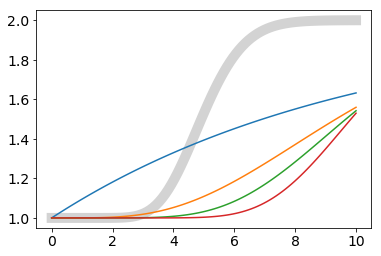

In [8]:
## Compare with a constructed transfer function 1/(s+sT/N)^N
plt.plot(t,x_N/V_i,lw=10,color='lightgrey')
for N_lump in N_lumps:
    V_i = V_p/N_lump
    lump = con.tf(1,[V_i,1])
    lumps = con.tf(1,1)
    for i in range(N_lump):
        lumps = con.series(lumps,lump)
#     print(lumps)
    t,y = con.step_response(lumps,T=t)
    plt.plot(t,y+1)


In [9]:
## Redo for particular case
N_lump = 10
UniDir = []
for i in range(N_lump+1):
    reac = f'r_{i}'
Pipe = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                  N=N_lump+1,rename_components=True,Comps=['R'],quiet=quiet)
s = st.stoich(Pipe,UniDir=None, quiet=quiet)
s['name'] = 'Pipe_abg'
stbg.model(s)
disp.Latex(st.sprintrl(s,chemformula=True))


<IPython.core.display.Latex object>

## Transfer-function analysis
This chain of reactions has liner dynamics which are extracted to give a model in the Python Control Toolbox format. The effective timeconstant is computed from:
\begin{equation}
\tau = \sum_{i=1}^N 1/p_i
\end{equation}
where $p_i$ is the $i$th pole of the tranfer function relating the input and output of the chain.

In [10]:
imp.reload(st)
UniDir=[]
for i in range(N_lump+1):
    UniDir.append(f'r_{i}')
print(UniDir)
s = st.stoich(Pipe,UniDir=UniDir, quiet=quiet)
disp.Latex(st.sprintvl(s))

['r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_10']


<IPython.core.display.Latex object>


                                             1
--------------------------------------------------------------------------------------------
s^10 + 10 s^9 + 45 s^8 + 120 s^7 + 210 s^6 + 252 s^5 + 210 s^4 + 120 s^3 + 45 s^2 + 10 s + 1

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Time constant = 10.0


Text(0,0.5,'$y_{step}$ (normalised)')

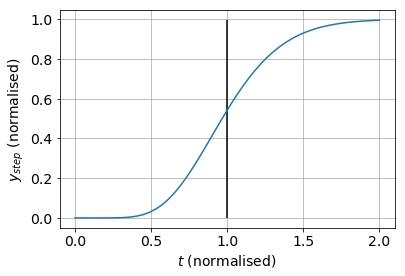

In [11]:
sc = st.statify(s,chemostats=['A','B'])
sys = st.lin(s,sc)
# print(sys)
A,B,C,D = con.ssdata(sys)
sys12 = con.ss(A,B[:,0],C[N_lump,:],0)
print(con.tf(sys12))
print(con.pole(sys12))
tc = np.sum(-1/con.pole(sys12))
gain = con.dcgain(sys12)
print('Time constant =',tc)
t_step,y_step = con.step_response(sys12,T=np.linspace(0,2*tc))
plt.plot(t_step/tc,y_step.T/gain)
plt.vlines(1,0,max(y_step)/gain)
plt.grid()
plt.xlabel('$t$ (normalised)')
plt.ylabel('$y_{step}$ (normalised)')

# Coupled Advection and Transformation

This corresponds to Section 4 of the paper.

## Orifice connection


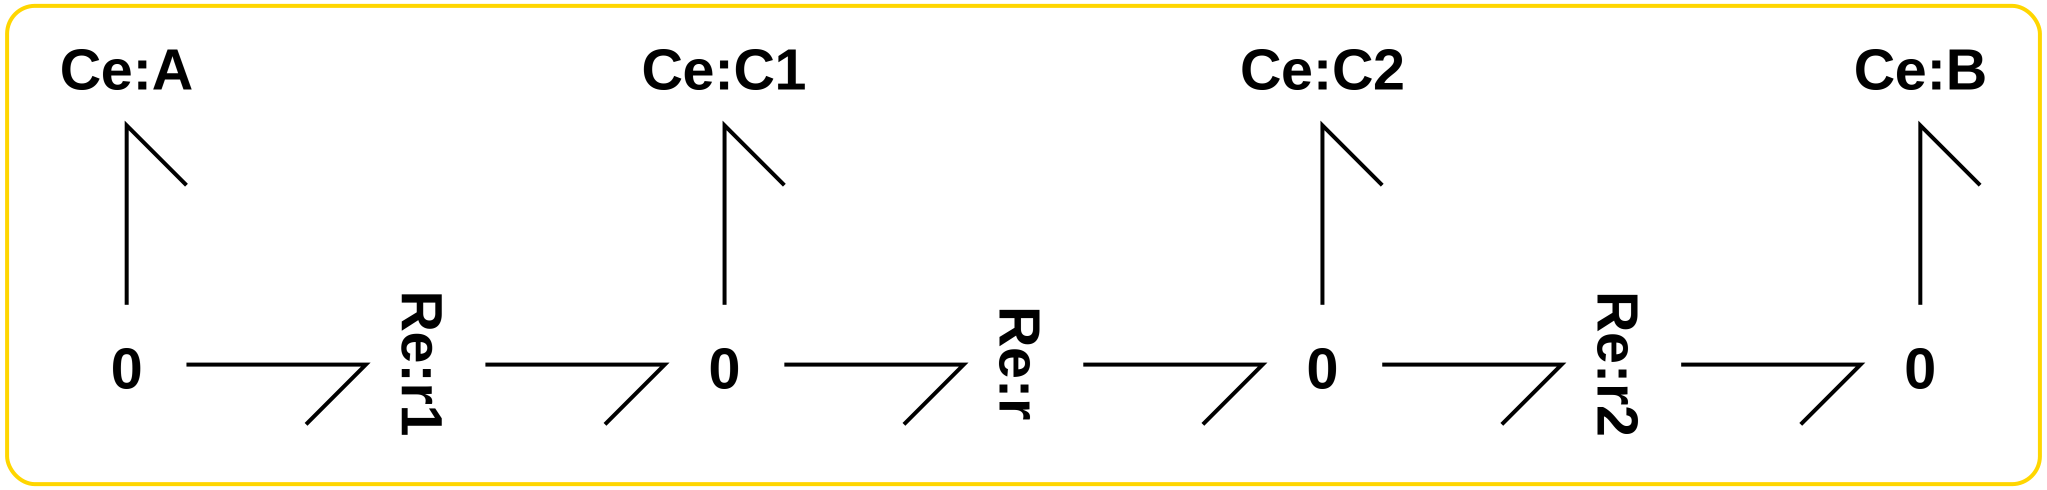

In [12]:
## 
sbg.model('splitReos_abg.svg')
import splitReos_abg
disp.SVG('splitReos_abg.svg')


In [13]:
##Stoichiometry
s = st.stoich(splitReos_abg.model(),quiet=quiet)
chemostats = ['A','B']
sc = st.statify(s,chemostats=chemostats)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

2*(1+8*np.heaviside(t-10,0.5))


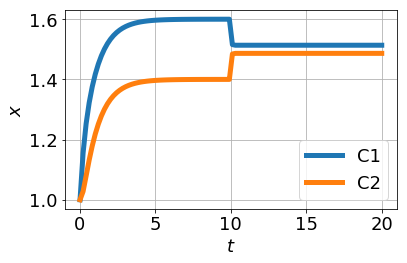

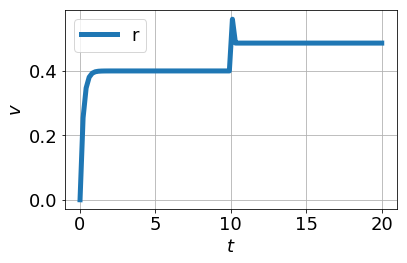

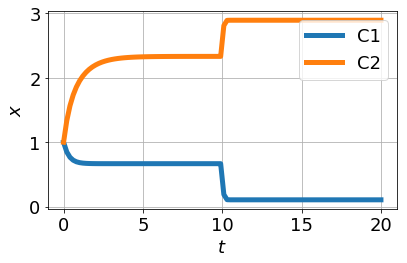

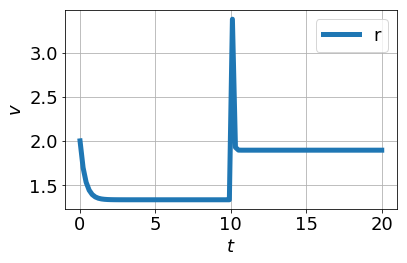

In [14]:
Q0 = 2
t1 = 10
f1 = 10-Q0
t = np.linspace(0,20,100)
Flow = f'{Q0}*(1+{f1}*np.heaviside(t-{t1},0.5))'
#Flow = f'{Q0}'
print(Flow)
## Simulation
species = s['species']
reaction = s['reaction']

X0 = np.ones(s['n_X'])
X0[species.index('A')] = 2
parameter = {}
Kappa = {}
for unidir in [False,True]:
    if unidir:
        UniDir=['r']
    else:
        UniDir=[]
        
    parameter['kappa_r1'] = parameter['kappa_r2'] = 1
    parameter['kappa_r'] = Q0
    Kappa['r'] = Flow
        
    s = st.stoich(splitReos_abg.model(),UniDir=UniDir, quiet=quiet)
    sc = st.statify(s,chemostats=chemostats)
    dat = st.sim(s,sc=sc,t=t,parameter=parameter,Kappa=Kappa,X0=X0,quiet=quiet)
    
    X_old = {}
    specPlot = ['C1','C2']
    plt.rcParams.update({'font.size': 18})
    for spec in specPlot:
        x = dat['X'][:,species.index(spec)]
        plt.plot(t,x,label=spec,lw=lw)
        X_old[spec] = x
    plt.grid()
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.tight_layout()
    name = f'Figs/splitReos_{unidir}'
    Savefig(name+'.pdf')
    plt.show()

    V_old = {}
    reacPlot = ['r']
    for reac in reacPlot:
        v = dat['V'][:,reaction.index(reac)]
        plt.plot(t,v,label=reac,lw=lw)
        V_old[reac] = v
    plt.grid()
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$v$')
    plt.tight_layout()
    
    name = f'Figs/splitReos_{unidir}_v'
    Savefig(name+'.pdf')
    plt.show()
    
x_B_0 = dat['X'][:,species.index('B')]
#     st.plot(s,dat,species=['A','B','C1','C2'])
#     st.plot(s,dat,species=[],filename=f'{name}_v.pdf')

## Pipe connection

In [15]:
## Create Pipe component
N_lump = 5
V_p = 10
Pipe = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                  N=N_lump+1,rename_components=True,Comps=['R'],quiet=quiet)
s = st.stoich(Pipe,UniDir=None, quiet=quiet)
s['name'] = 'Pipe_abg'
stbg.model(s)
import Pipe_abg
imp.reload(Pipe_abg)

<module 'Pipe_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2022/Advection/Pipe_abg.py'>

Creating subsystem: Pipe:p


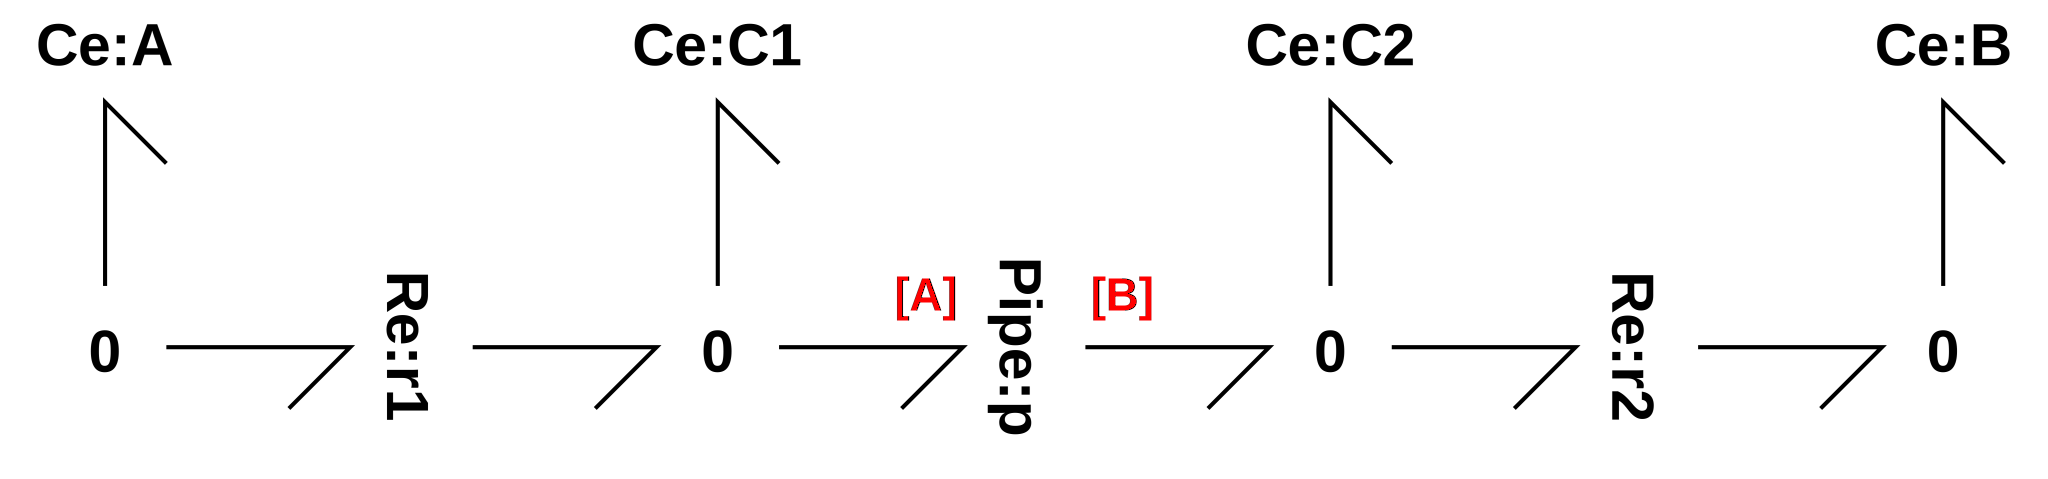

In [16]:
## Split enzyme catalysed Reaction
sbg.model('splitRep_abg.svg')
import splitRep_abg
disp.SVG('splitRep_abg.svg')


In [17]:
##Stoichiometry+parameters
parameter = {}
Kappa = {}
UniDir = []
for i in range(N_lump+1):
    reac = f'p_r_{i}'
    UniDir.append(reac)
    kap = f'kappa_{reac}'
    parameter[kap] = Q0
    Kappa[reac] = Flow
    
s = st.stoich(splitRep_abg.model(),UniDir=UniDir,quiet=quiet)
species = s['species']
sc = st.statify(s,chemostats=chemostats)

## Initial condition
X0 = np.ones(s['n_X'])
X0[species.index('A')] = 2


## Pipe parameters
small = 1e-6
if N_lump>0:
    V_i = V_p/N_lump # Volume of lump
    for i in range(N_lump):
        spec = f'p_IS{i+1}'
        K = f'K_{spec}'
        parameter[K] = 1/V_i
        X0[species.index(spec)] = small

# print(parameter)
# print(X0)
# print(parameter)
# print(UniDir)
print(Kappa)
        
disp.Latex(st.sprintrl(s,chemformula=True))


{'p_r_0': '2*(1+8*np.heaviside(t-10,0.5))', 'p_r_1': '2*(1+8*np.heaviside(t-10,0.5))', 'p_r_2': '2*(1+8*np.heaviside(t-10,0.5))', 'p_r_3': '2*(1+8*np.heaviside(t-10,0.5))', 'p_r_4': '2*(1+8*np.heaviside(t-10,0.5))', 'p_r_5': '2*(1+8*np.heaviside(t-10,0.5))'}


<IPython.core.display.Latex object>

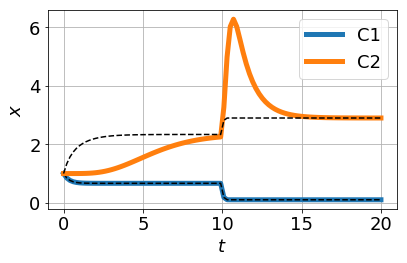

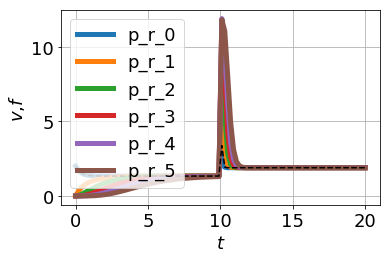

In [18]:

## Simulate
dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,Kappa=Kappa,quiet=quiet)

plt.rcParams.update({'font.size': 18})
for spec in specPlot:
    x = dat['X'][:,species.index(spec)]
    plt.plot(t,x,label=spec,lw=lw)
    plt.plot(t,X_old[spec],color='black',ls='dashed')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.tight_layout()
Savefig('Figs/splitRep.pdf')
plt.show()

reaction = s['reaction']
for i in range(N_lump+1):
    reac = f'p_r_{i}'
    v = dat['V'][:,reaction.index(reac)]
    plt.plot(t,v,label=reac,lw=lw)
plt.plot(t,V_old['r'],color='black',ls='dashed')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$v$,$f$')
plt.tight_layout()
name = f'Figs/splitRep_v'
Savefig(name+'.pdf')
plt.show()

In [19]:
# st.plot(s,dat,reaction=[],species=['A','B','C1','C2'])

In [20]:
#  st.plot(s,dat,species=[])

In [21]:
# st.plot(s,dat,reaction=[],species=['p_IS1'])

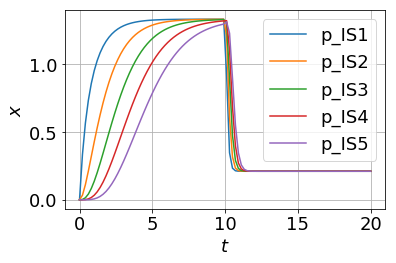

In [22]:
for i,spec in enumerate(species):
    if 'I' in spec:
        x = dat['X'][:,i]
        plt.plot(t,x,label=spec)
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.tight_layout()
Savefig('Figs/splitRep_pipe.pdf')

# Enzyme-catalysed reaction
This section reprises the standard bond graph model of an enzyme-catalysed reaction -- see [ECR](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/ECR.ipynb).
In this case:
- **Ce_A** represents the unbound oxygen entering the blood
- **Ce_B** represents the unbound oxygen leaving the blood
- **Ce_E** represents the unbound haemoglobin
- **Ce_C** represents the haemoglobin bound to oxygen

This corresponds to a simple model of haemoglobin with one binding site (like myoglobin). A more detailed model wouPipe incorporate four cooperative binding sites -- see [Cooperative](https://github.com/gawthrop/BondGraphTools-Biomolecular/blob/master/Cooperative.ipynb).

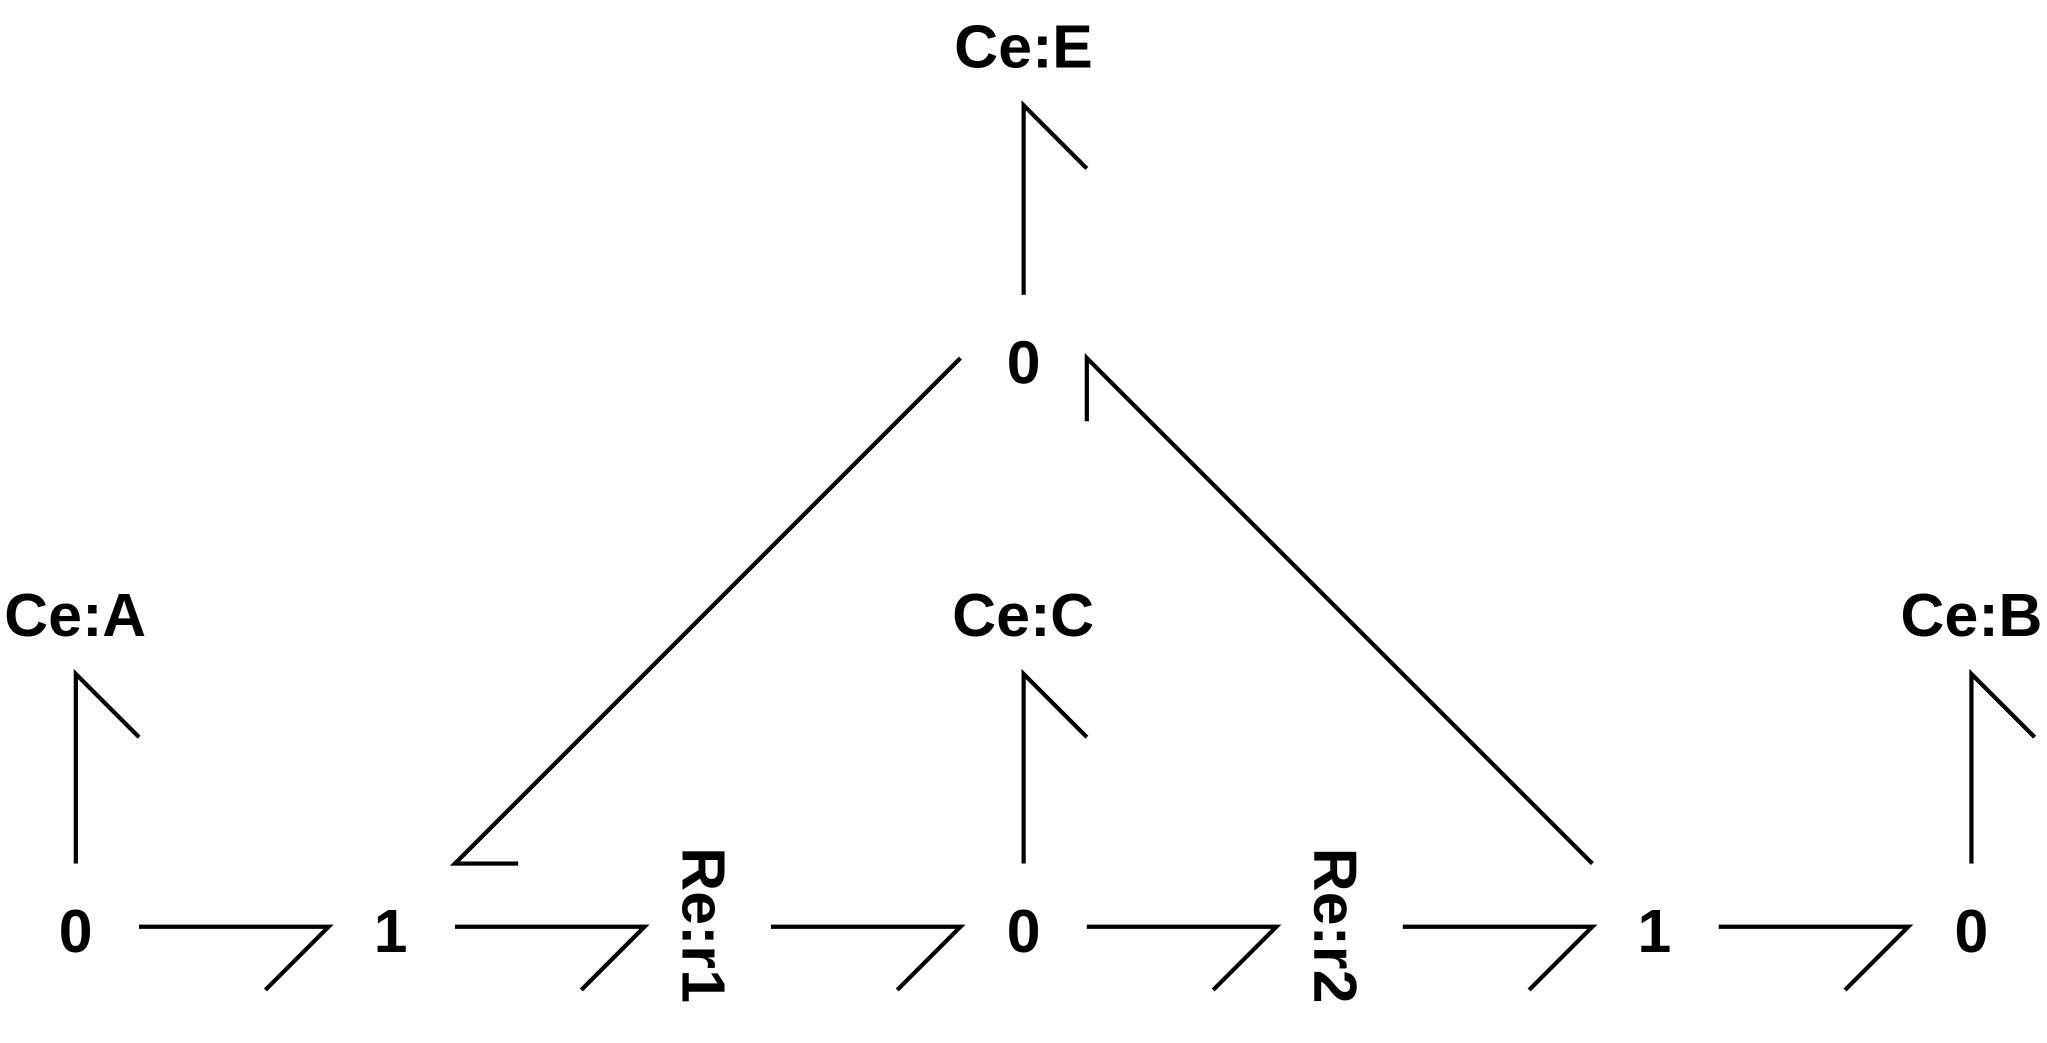

In [23]:
## Enzyme catalysed reaction
sbg.model('RE_abg.svg')
import RE_abg
disp.SVG('RE_abg.svg')


In [24]:
##Stoichiometry
s = st.stoich(RE_abg.model(),quiet=quiet)
chemostats = ['A','B']
sc = st.statify(s,chemostats=chemostats)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

## Split enzyme-catalysed reaction
In this bond graph, the components **Ce_E** and **Ce_E** are split: advection carries the coreponding molecules from one side to the other. An explicit bond graph for this coupling is provided below for tghe case were the advection time-delay is zero; the bond graph for the general case has not yet been determined.

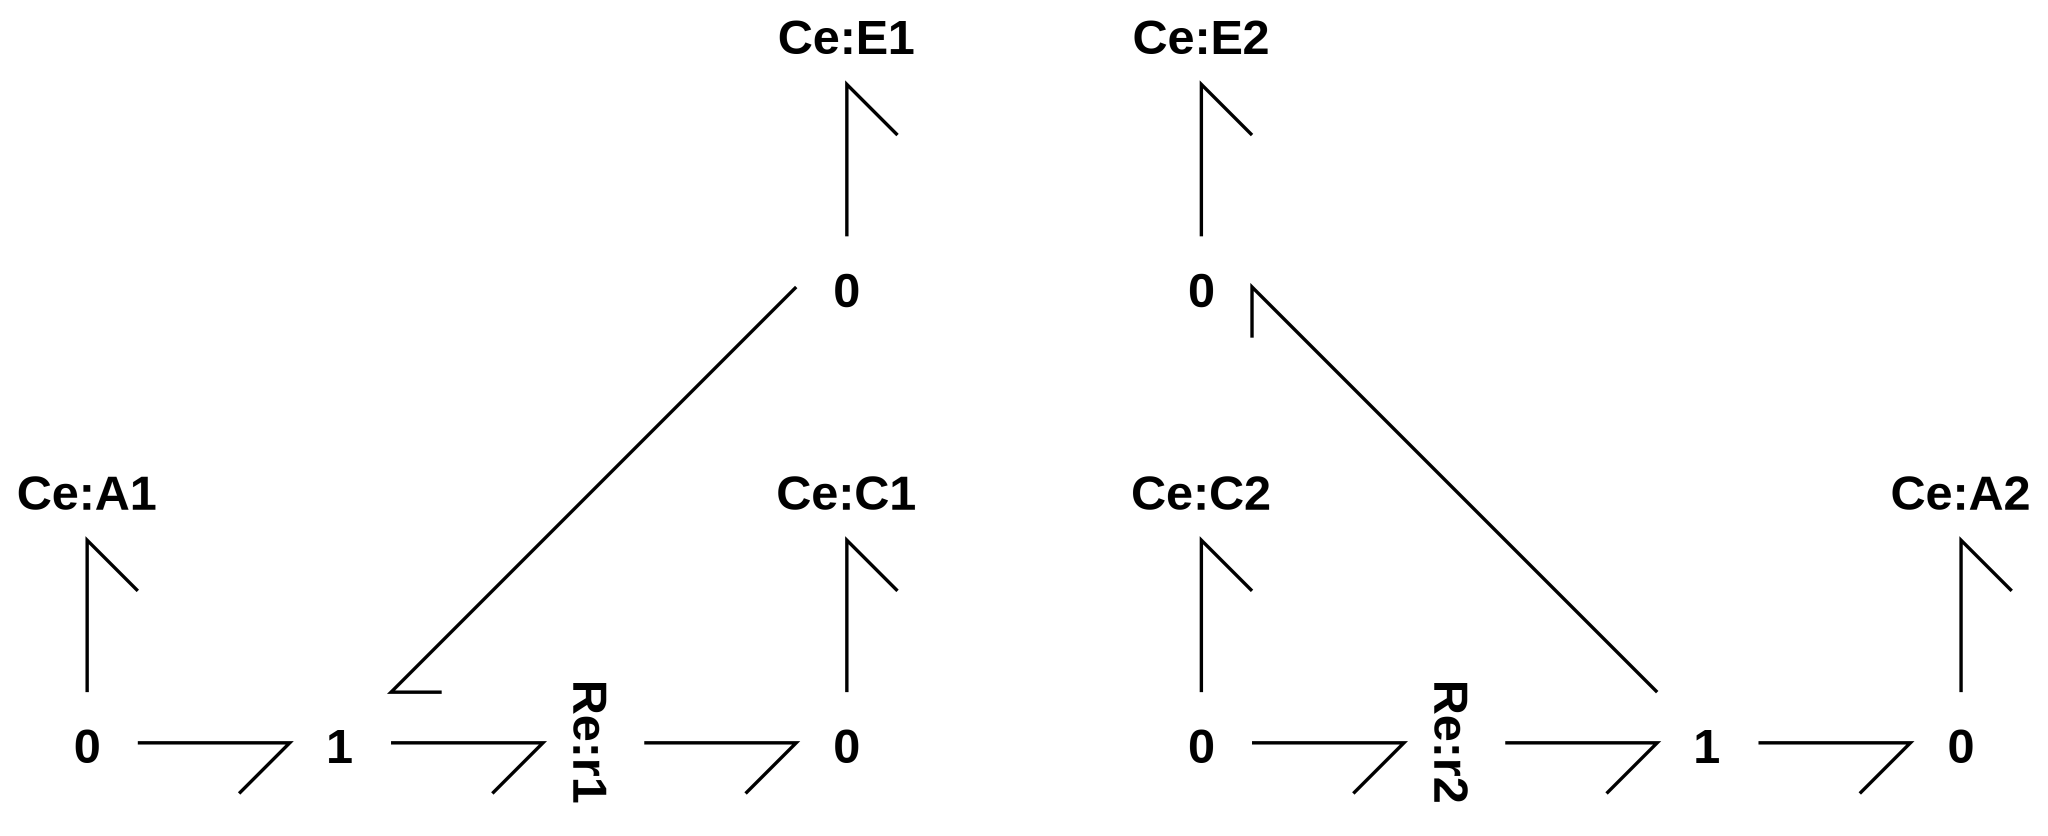

In [25]:
## Split enzyme catalysed reaction
sbg.model('splitRE_abg.svg')
import splitRE_abg
disp.SVG('splitRE_abg.svg')


In [26]:
##Stoichiometry
ss = st.stoich(splitRE_abg.model(),quiet=quiet)
chemostats = ['A1','A2']
ssc = st.statify(ss,chemostats=chemostats)
disp.Latex(st.sprintrl(ss,chemformula=True))

<IPython.core.display.Latex object>

# Circular advection


## Orifice (Symmetric case): Bond graph model

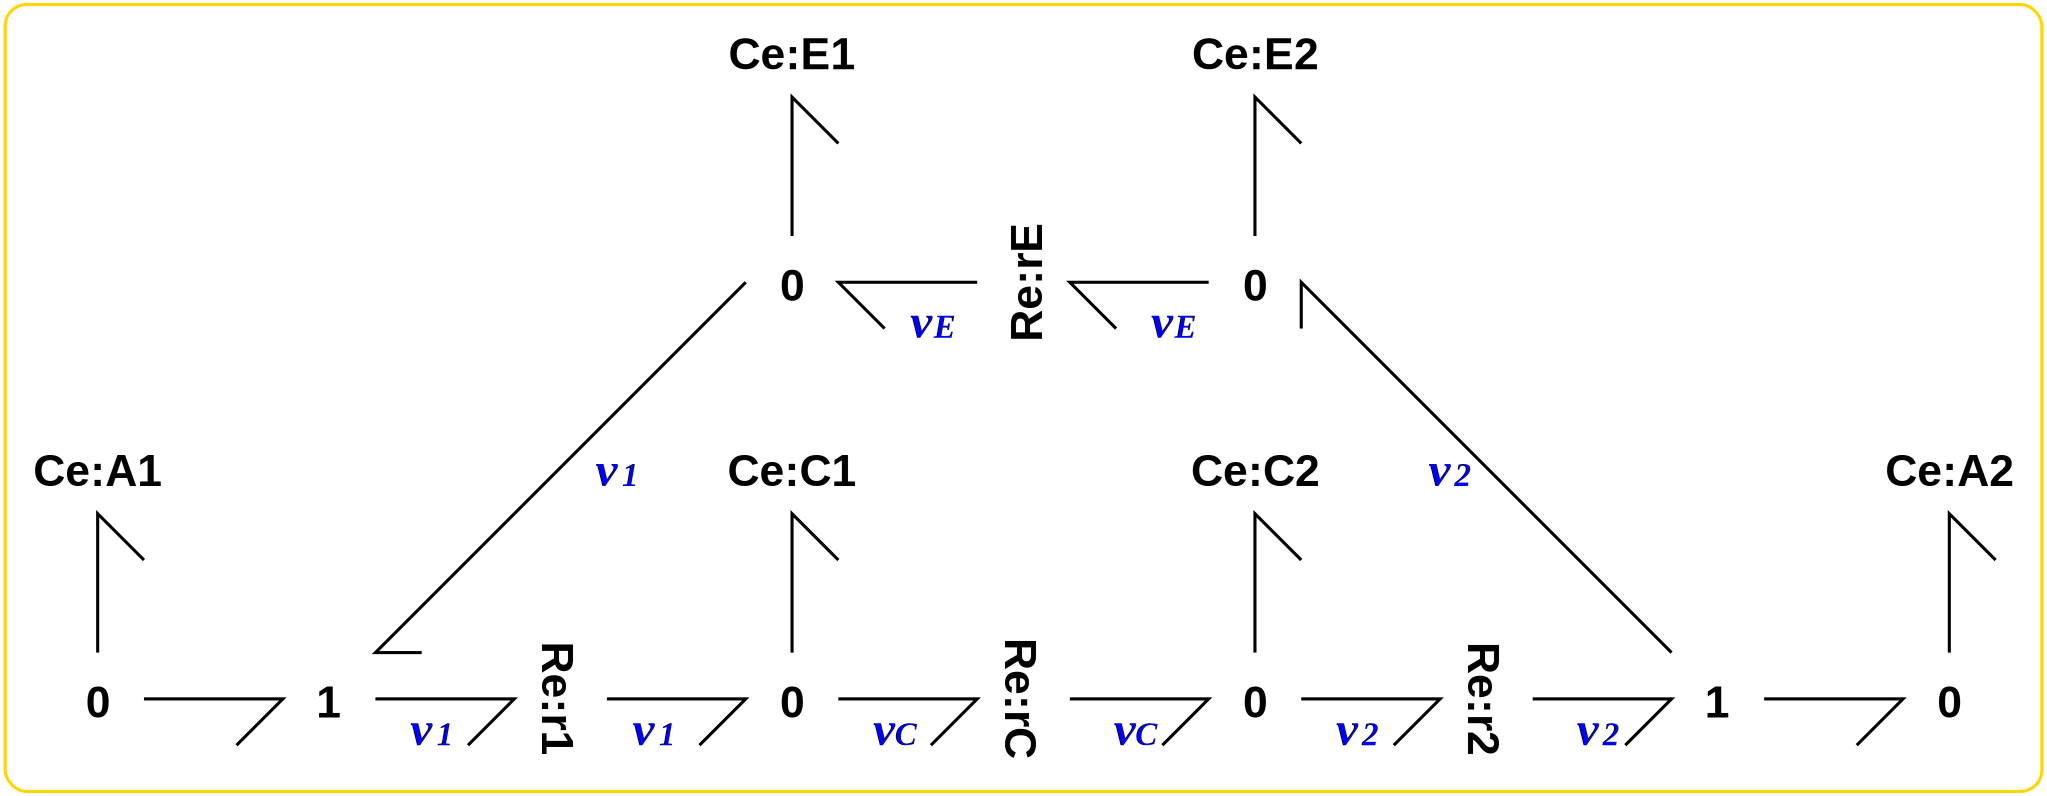

In [27]:
## Split enzyme catalysed reaction with symmetric connection
sbg.model('splitREos_abg.svg')
import splitREos_abg
disp.SVG('splitREos_abg.svg')


In [28]:
##Stoichiometry
snd = st.stoich(splitREos_abg.model(),quiet=quiet)
chemostats = ['A1','A2']
sndc = st.statify(snd,chemostats=chemostats)
print(snd['species'])
print(snd['reaction'])
disp.Latex(st.sprintrl(snd,chemformula=True))

['A1', 'A2', 'C1', 'C2', 'E1', 'E2']
['r1', 'r2', 'rC', 'rE']


<IPython.core.display.Latex object>

### Simulate 
Note that 
- the final steady state of the two cases $d=0$ and $d>0$ are the same
- if the simulation is repeated with $f_0=100$, the $x_{C1}\approx x_{C2}$ and $x_{E1}\approx x_{E2}$ as predicted.

The two chemostats corresponding to A1 and A2 are:
\begin{align}
x_{A1} &= \begin{cases}
    1 & \text{if $t<1$}\\
    2 & \text{if $t\ge 1$}
    \end{cases}\\
x_{A2} &= 1
\end{align}

In [29]:
## Simulate split ECR with no delay
i_chemo = []
for chemo in chemostats:
    i_chemo.append(snd['species'].index(chemo))
# print(i_chemo)
## Time
tt = np.linspace(0, 20,10000)

## Parameters
parameter = {}
parameter['kappa_rC'] = Q0
parameter['kappa_rE'] = Q0

# parameter['K_E'] = 0.5
# parameter['K_C'] = 0.5
## Chemostats
t_0 = 0
X_chemo = {'A1':f'1 + np.heaviside(t-{t_0},1)', 'A2':'1'}

## Simulate
dat = st.sim(snd,sc=sndc,t=tt,parameter=parameter,X_chemo=X_chemo,quiet=False)
XX0 = dat['X'][:,2:6]
Legend = snd['species'][2:6]
V0 = dat['V'][:,0:2]
dX0 = dat['dX'][:,i_chemo]

Setting kappa_rC to 2
Setting kappa_rE to 2


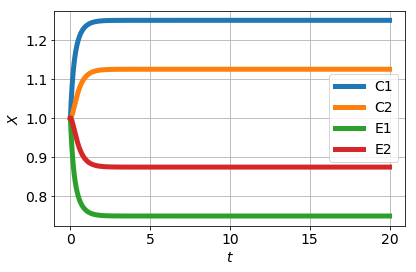

In [30]:
## Plot
plt.rcParams.update({'font.size': 14})
## Orifice
plt.plot(tt,XX0,lw=lw)

plt.legend(Legend)
plt.grid()
plt.xlabel('$t$')
plt.ylabel('$X$')
plt.tight_layout()
Savefig('Figs/OrificeSim.pdf')



## Circular advection: pipe connection 

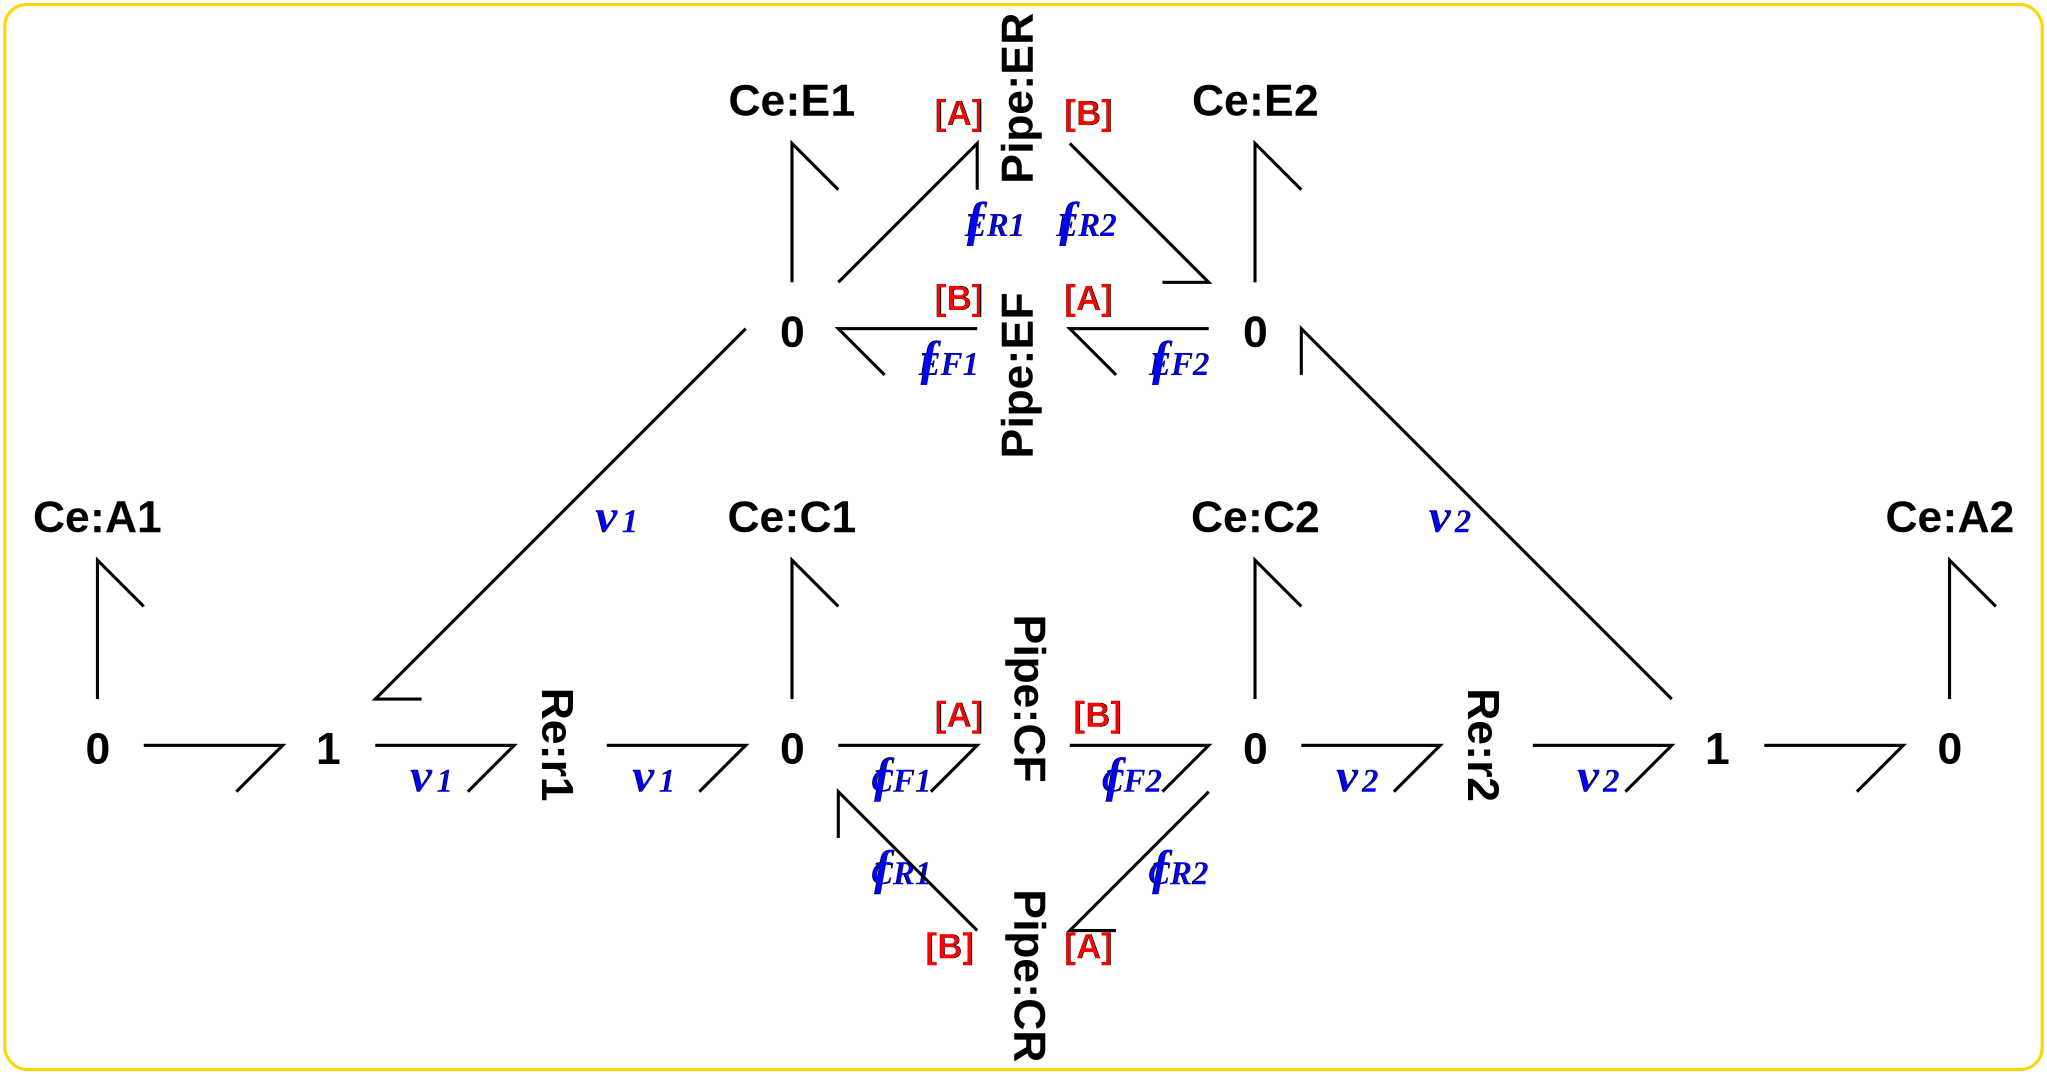

In [31]:
disp.SVG('splitREp_abg.svg')

In [32]:
def CircularAdvection(N_lump=5,Flow=f'{Q0}', quiet=True):
    
    ## Create Pipe component
    ## Note: N_lump = 0 corresponds to orifice case.
    Pipe = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                        N=N_lump+1,rename_components=True,Comps=['R'],quiet=quiet)
    s = st.stoich(Pipe,UniDir=None, quiet=quiet)
    s['name'] = 'Pipe_abg'
    stbg.model(s)

    ## Set uni directional Re components
    UniDir = []
    for i in range(N_lump+1):
        for comp in ['EF','ER','CF','CR']:
            ud = f'{comp}_r_{i}'
            UniDir.append(ud)

    # print(UniDir)
    ## Create stoichiometry
    sbg.model('splitREp_abg.svg')
    import Pipe_abg
    imp.reload(Pipe_abg)
    import splitREp_abg
    imp.reload(splitREp_abg)
    sPipe = st.stoich(splitREp_abg.model(),UniDir=UniDir,quiet=quiet)
    
    if not quiet:
        disp.Latex(st.sprintrl(sPipe,chemformula=True))

    ## Setup parameters
    parameter = {}
    Kappa = {}
    
    ## Assume K=KK is same for all species
    ## Note that in the simulation code K corresponds to KK/V_i
    KK = 1
    
    for i in range(N_lump+1):
        for comp in ['EF','ER','CF','CR']:
            kap = f'{comp}_r_{i}'
            Kappa[kap] = f'({Flow})/{KK}'
            #parameter[kap] = Q0
            if i>0:
                V_i = V_p/N_lump
                K0 = KK/V_i
                K0F = K0
                K0R = K0
                K = f'K_{comp}_IS{i}'
                if 'F' in comp:
                    parameter[K] = K0F
                else:
                    parameter[K] = K0R


    ## Setup initial states
    X0 = []
    small = 1e-6
    for spec in sPipe['species']:
    #     print(spec)
        if 'IS' in spec:
            K = f'K_{spec}'
            Xi = 1/parameter[K]
#             Xi = small
        else:
            Xi = 1
        X0.append(Xi)

    X0 = np.array(X0)

#     print(Kappa)
#     print(sPipe['reaction'])
    ## Simulate
    chemostats=['A1','A2']
    i_chemo = []
    for chemo in chemostats:
        i_chemo.append(sPipe['species'].index(chemo))
    # print(i_chemo)
    sPipec = st.statify(sPipe,chemostats=chemostats)
    dat = st.sim(sPipe,sc=sPipec,t=tt,parameter=parameter,Kappa=Kappa,X0=X0,X_chemo=X_chemo,quiet=quiet)
    
    return sPipe,dat,i_chemo

Creating subsystem: Pipe:CF
Creating subsystem: Pipe:CR
Creating subsystem: Pipe:EF
Creating subsystem: Pipe:ER
N_lump = 0


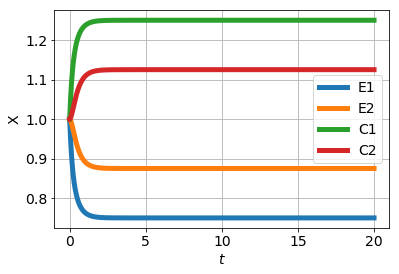

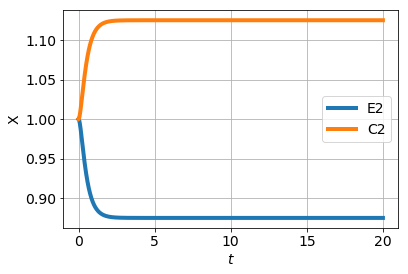

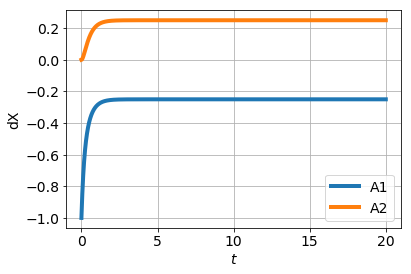

In [33]:
#Orifice (Pipe with no lumps)
N_lump = 0
sPipe0,dat0,i_chemo0 = CircularAdvection(N_lump=N_lump)

print('N_lump =', N_lump)

plt.rcParams.update({'font.size': 14})

st.plot(sPipe0,dat0,species=['E1','E2','C1','C2'], reaction = [],lw=5)
#st.plot(sPipe,dat,species=[], reaction = ['PipeEF_r_0','PipeCF_r_0'])
st.plot(sPipe0,dat0,species=['E2','C2'], reaction = [])
st.plot(sPipe0,dat0,dX=True,species=['A1','A2'], reaction = [])

Creating subsystem: Pipe:CF
Creating subsystem: Pipe:CR
Creating subsystem: Pipe:EF
Creating subsystem: Pipe:ER
N_lump = 5


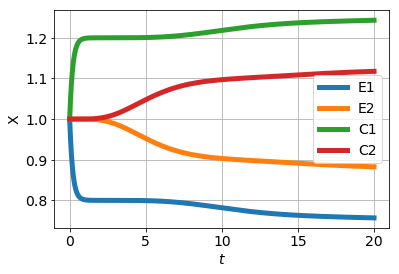

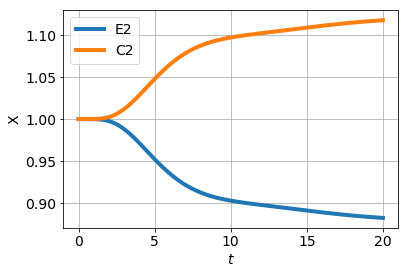

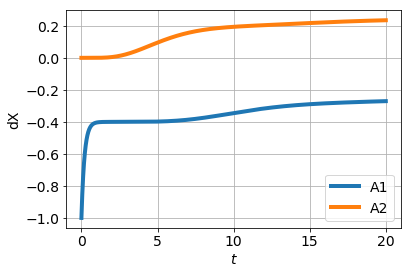

In [34]:
#Pipe
N_lump = 5
sPipe,dat,i_chemo = CircularAdvection(N_lump=N_lump)

print('N_lump =', N_lump)
st.plot(sPipe,dat,species=['E1','E2','C1','C2'], reaction = [],lw=lw)
#st.plot(sPipe,dat,species=[], reaction = ['PipeEF_r_0','PipeCF_r_0'])
st.plot(sPipe,dat,species=['E2','C2'], reaction = [])
st.plot(sPipe,dat,dX=True,species=['A1','A2'], reaction = [])

Text(0,0.5,'$X$')

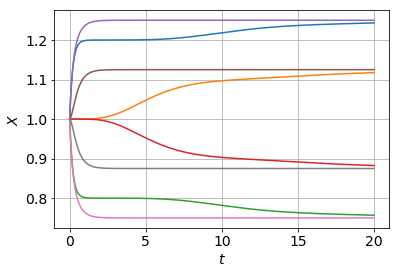

In [35]:
## Extract data
XXPipe = dat['X'][:,2:6]
VPipe = dat['V'][:,[0,N_lump+1]]
dXPipe = dat['dX'][:,i_chemo]
dXPipe0 = dat0['dX'][:,i_chemo]

## Plot and compare
## Pipe
plt.plot(tt,XXPipe)

## Orifice
plt.plot(tt,XX0)

plt.grid()
plt.xlabel('$t$')
plt.ylabel('$X$')




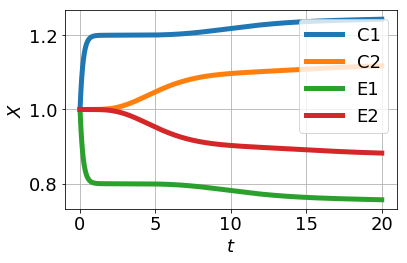

In [36]:
## Plot

## Pipe
## Font
plt.rcParams.update({'font.size': 18})
plt.plot(tt,XXPipe,lw=lw)

plt.legend(Legend)
plt.grid()
plt.xlabel('$t$')
plt.ylabel('$X$')
plt.tight_layout()
Savefig('Figs/PipeSim.pdf')



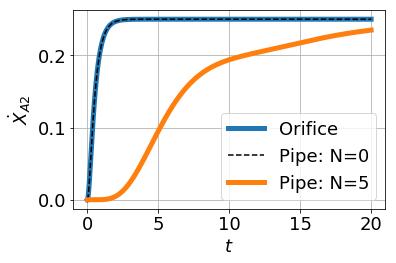

In [37]:
## Plot Chemostat flows
##Orifice
plt.plot(tt,dX0[:,1],label='Orifice',lw=lw)

## Pipe
plt.plot(tt,dXPipe0[:,1],label='Pipe: N=0',linestyle='dashed',color='black')
plt.plot(tt,dXPipe[:,1],label=f'Pipe: N={N_lump}',lw=lw)

plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\dot{X}_{A2}$')
plt.tight_layout()
Savefig('Figs/PipeSim_flow.pdf')


# Variable flow rate

Flow: (2)*(1+0.5*np.sin(2*np.pi*t/5))
Creating subsystem: Pipe:CF
Creating subsystem: Pipe:CR
Creating subsystem: Pipe:EF
Creating subsystem: Pipe:ER
N_lump = 5


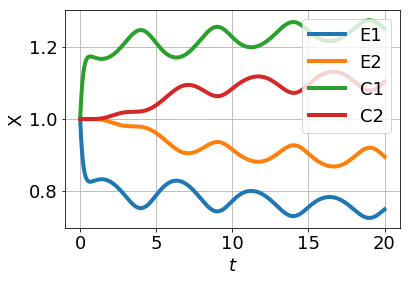

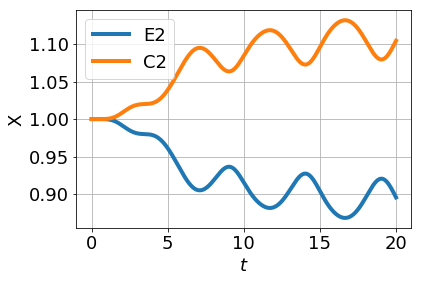

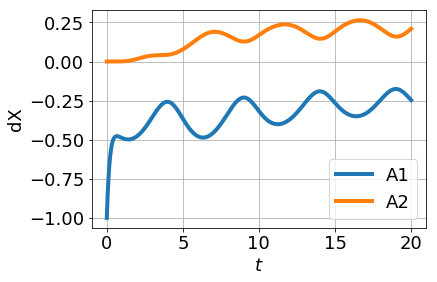

In [38]:
N_lump = 5
Period = 5
Flow = f'({Q0})*(1+0.5*np.sin(2*np.pi*t/{Period}))'
print('Flow:',Flow)
sPipe,dat,i_chemo = CircularAdvection(N_lump=N_lump,Flow=Flow)

print('N_lump =', N_lump)
st.plot(sPipe,dat,species=['E1','E2','C1','C2'], reaction = [])
#st.plot(sPipe,dat,species=[], reaction = ['PipeEF_r_0','PipeCF_r_0'])
st.plot(sPipe,dat,species=['E2','C2'], reaction = [])
st.plot(sPipe,dat,dX=True,species=['A1','A2'], reaction = [])

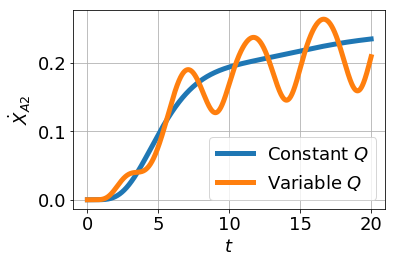

In [39]:
## Extract data
XXPipev = dat['X'][:,2:6]
VPipev = dat['V'][:,[0,N_lump+1]]
dXPipev = dat['dX'][:,i_chemo]


## Plot Chemostat flows
## Pipe
## Font
plt.rcParams.update({'font.size': 18})

plt.plot(tt,dXPipe[:,1],label='Constant $Q$',lw=lw)
plt.plot(tt,dXPipev[:,1],label='Variable $Q$',lw=lw)
#plt.plot(tt,Q/4,ls='dashed',label='$Q/4$')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\dot{X}_{A2}$')
plt.tight_layout()
Savefig('Figs/PipeSim_flow_vary.pdf')


# Pharmacokinetics

The data is taken from <cite data-cite="Map73">(Mapleson, 1973)</cite>.

In [40]:
# sbg.model('Lung_abg.svg')
# disp.SVG('Lung_abg.svg')

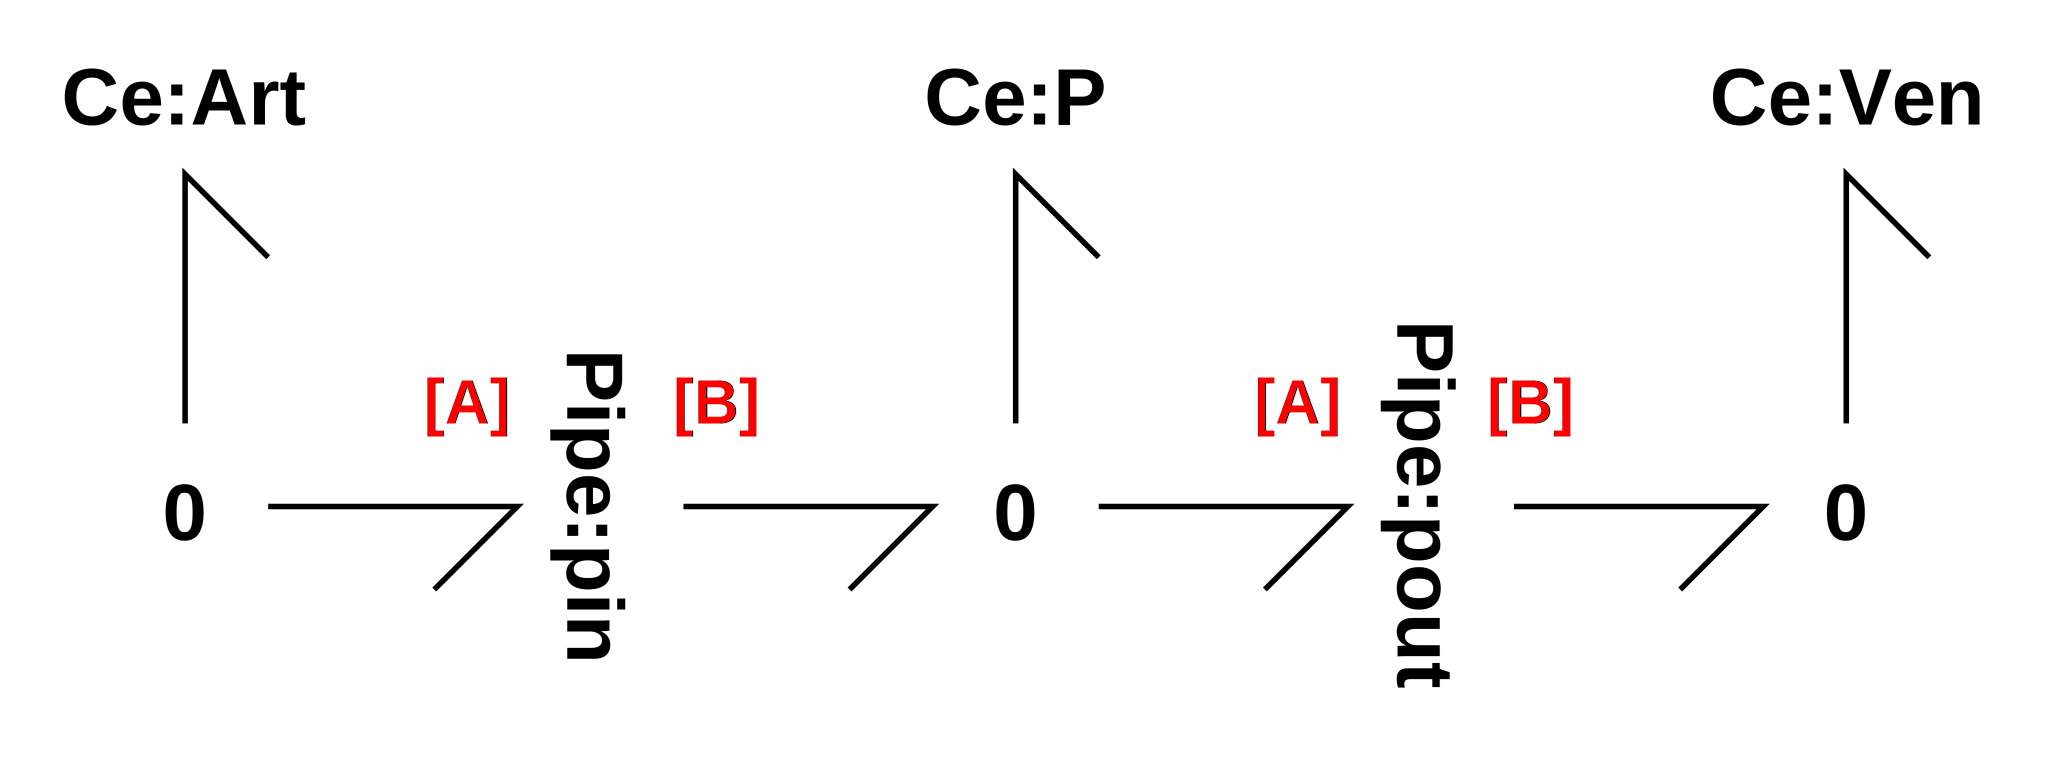

In [41]:
disp.SVG('Pool_abg.svg')

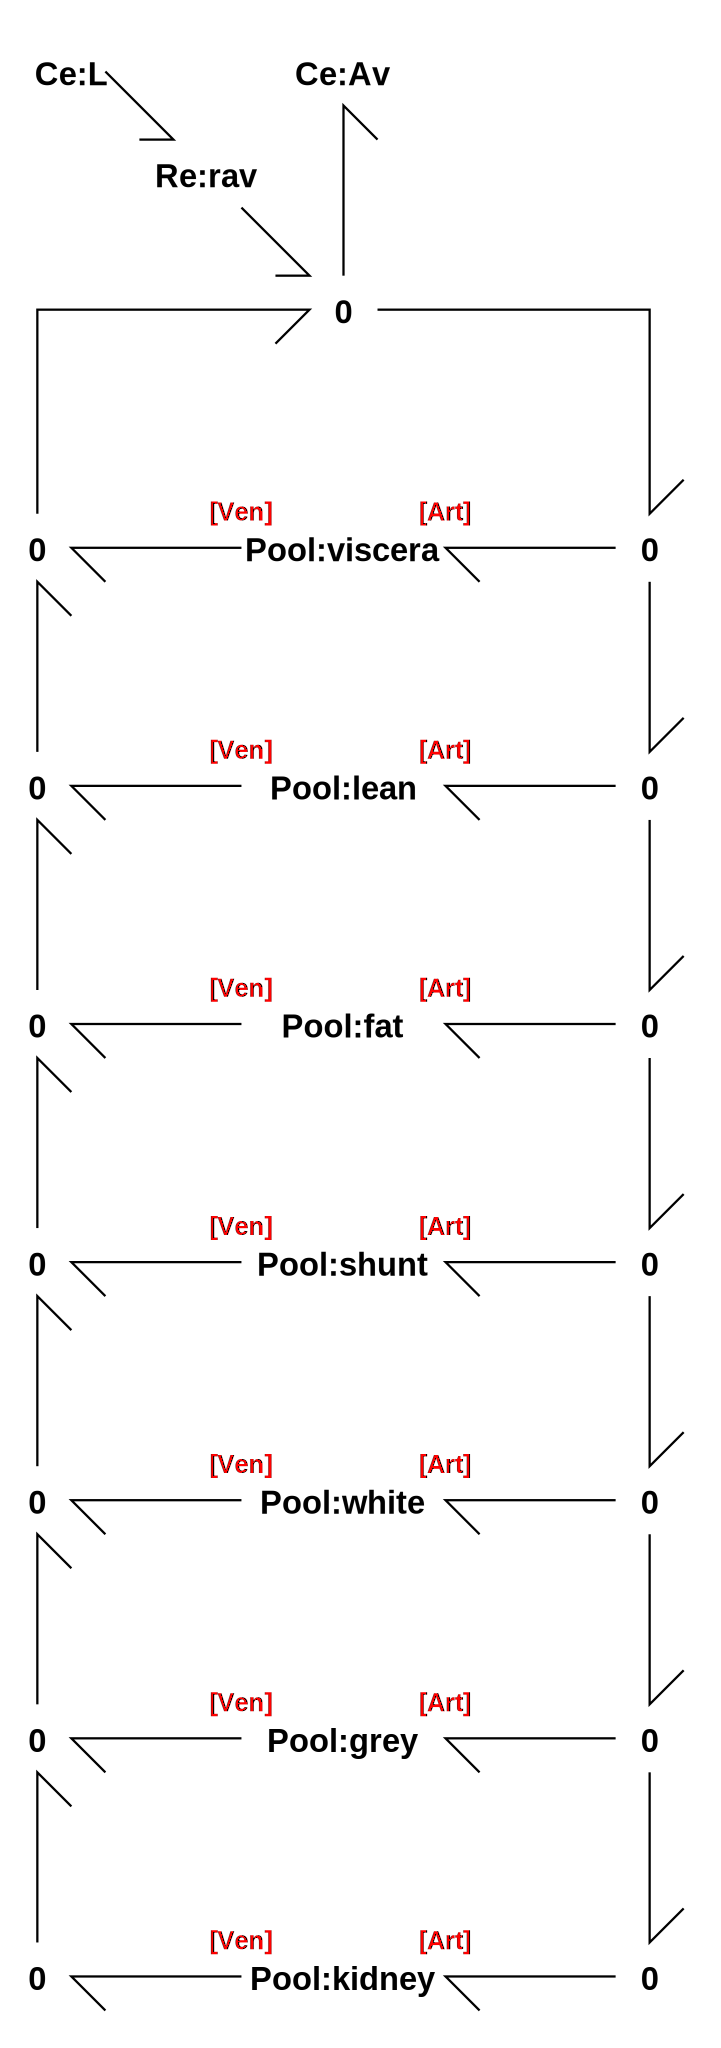

In [42]:
disp.SVG('PK_abg.svg')

In [43]:
def Pool(N_lump=0, quiet=True):
    
    ## Create Pipe component
    ## Note: N_lump = 0 corresponds to orifice case.
    Pipe = mbg.chain(AB_abg.model(),inport = 'A',outport = 'B',
                        N=N_lump+1,rename_components=True,Comps=['R'],quiet=quiet)
    s = st.stoich(Pipe,UniDir=None, quiet=quiet)
    s['name'] = 'Pipe_abg'
    stbg.model(s)

    ## Set unidirectional Re components
    UniDir = []
    for i in range(N_lump+1):
        for comp in ['pin','pout']:
            ud = f'{comp}_r_{i}'
            UniDir.append(ud)

    # print(UniDir)
    ## Create stoichiometry
    sbg.model('Pool_abg.svg')
    import Pipe_abg
    imp.reload(Pipe_abg)
    import Pool_abg
    imp.reload(Pool_abg)
    sPool = st.stoich(Pool_abg.model(),UniDir=UniDir,quiet=quiet)
    
    
    if not quiet:
        disp.Latex(st.sprintrl(sPool,chemformula=True))
        
    ## Flatten
    stbg.model(sPool,filename='Pool_abg')
        
    return UniDir

def setPool(N_lump=0,Flow=f'{Q0}', quiet=True):
    ## Setup parameters
    parameter = {}
    Kappa = {}
    
    ## Assume K=KK is same for all species
    ## Note that in the simulation code K corresponds to KK/V_i
    KK = 1
    
    for i in range(N_lump+1):
        for comp in ['pin','pout']:
            kap = f'{comp}_r_{i}'
            Kappa[kap] = f'({Flow})/{KK}'
            #parameter[kap] = Q0
            if i>0:
                V_i = V_p/N_lump
                K0 = KK/V_i
                K0F = K0
                K0R = K0
                K = f'K_{comp}_IS{i}'
                if 'f' in comp:
                    parameter[K] = K0F
                else:
                    parameter[K] = K0R


    ## Setup initial states
    X0 = []
    for spec in sPool['species']:
    #     print(spec)
        if 'IS' in spec:
            K = f'K_{spec}'
            Xi = 1/parameter[K]
        else:
            Xi = 1
        X0.append(Xi)

    X0 = np.array(X0)


    return parameter,X0

In [44]:
N_lump = 5
UniDir = Pool(N_lump=N_lump)
import Pool_abg
imp.reload(Pool_abg)
sPool = st.stoich(Pool_abg.model(),UniDir=UniDir,quiet=quiet)
print(sPool['name'])
print(UniDir)
disp.Latex(st.sprintrl(sPool,chemformula=True))

Creating subsystem: Pipe:pin
Creating subsystem: Pipe:pout
Pool
['pin_r_0', 'pout_r_0', 'pin_r_1', 'pout_r_1', 'pin_r_2', 'pout_r_2', 'pin_r_3', 'pout_r_3', 'pin_r_4', 'pout_r_4', 'pin_r_5', 'pout_r_5']


<IPython.core.display.Latex object>

In [45]:
import Pool_abg
imp.reload(Pool_abg)
sbg.model('PK_abg.svg')
import PK_abg
imp.reload(PK_abg)
pools = ['viscera','lean','fat','shunt','white','grey','kidney']
PK_UniDir = []
for pool in pools:
    for ud in UniDir:
        PKud = f'{pool}_{ud}'
        PK_UniDir.append(PKud)
# print(PK_UniDir)
sPK = st.stoich(PK_abg.model(),UniDir=PK_UniDir, quiet=quiet)

Creating subsystem: Pool:fat
Creating subsystem: Pool:grey
Creating subsystem: Pool:kidney
Creating subsystem: Pool:lean
Creating subsystem: Pool:shunt
Creating subsystem: Pool:viscera
Creating subsystem: Pool:white


In [46]:
disp.Latex(st.sprintrl(sPK,chemformula=True))

<IPython.core.display.Latex object>

In [47]:
# disp.Latex(st.sprintvl(sPK))

## Parameters: Map78 Table I

In [48]:
## Parameters: Volume
Volume={}
Volume['lung'] = 0.6
Volume['Lout'] = 0.3
Volume['Lin'] = 0.3
Volume['viscera'] = 6.2
Volume['lean'] = 39.2
Volume['fat'] = 12.2 
Volume['shunt'] = 1e-6
Volume['white'] = 0.0007
Volume['grey'] = 0.0007
Volume['kidney'] = 0.0007

Volume['arterial'] = 1.4
Volume['venous'] = 4.0


In [49]:
## Parameters: Flow
FlowFraction={}
FlowFraction['viscera'] = 0.63
FlowFraction['lean'] = 0.131
FlowFraction['fat'] = 0.04
FlowFraction['shunt'] = 0.199
FlowFraction['white'] = 0.000022
FlowFraction['grey'] = 0.000086
FlowFraction['kidney'] = 0.000432

In [50]:
## Parameters: Partition coefficient
PartitionCoefficient = {}
for pool in pools:
    if pool in ['fat']:
        PartitionCoefficient[pool] = 1.40
    else:
        PartitionCoefficient[pool] = 0.46
print(PartitionCoefficient)

{'viscera': 0.46, 'lean': 0.46, 'fat': 1.4, 'shunt': 0.46, 'white': 0.46, 'grey': 0.46, 'kidney': 0.46}


In [51]:
Q = 6.48/60 # lit/sec Table II
Delay = {}
Delay_min = {}
for blood in ['arterial','venous']:
    Delay[blood] = Volume[blood]/Q
    Delay_min[blood] = Delay[blood]/60
    print(f'Delay ({blood}) = {Delay[blood]:.2f} sec = {Delay_min[blood]:0.2f} min')


parameter = {}

## Lung diffusion parameters
parameter['kappa_rav'] = 0.5
parameter['K_L'] = 1
parameter['K_Av'] = 0.05

## Pool parameters
for pool in pools:
    
    ## Pool Ce:P
    K = f'K_{pool}'
    par = 1/(Volume[pool]*PartitionCoefficient[pool])
#     frac = VolumeFraction[pool]
#     frac = 0.5 # FIXME
    parameter[f'{K}_P'] = par

    ## Pool pipes RA components
    for i in range(N_lump+1):
        for inout in ['in','out']:
            kappa = f'kappa_{pool}_p{inout}_r_{i}'
            parameter[kappa] = Q*FlowFraction[pool]
    
    ## Pool pipes C components
    if N_lump>0:
        for i in range(N_lump):
            for inout in ['in','out']:
                K = f'K_{pool}_p{inout}_IS{i+1}'
                if inout in ['in']:
                    V_i = FlowFraction[pool]*Volume['arterial']/N_lump
                else:
                    V_i = FlowFraction[pool]*Volume['venous']/N_lump
                parameter[K] = (1/V_i)
 
    
#print(parameter)

Delay (arterial) = 12.96 sec = 0.22 min
Delay (venous) = 37.04 sec = 0.62 min


## Simulation

In [52]:
## Simulation
t = np.linspace(0,360,1000)
# t = np.linspace(0,1000,1000)
# t = np.linspace(0,1000,1000)
t_ss = np.linspace(0,10000,1000)
t_1 = 120

## Initial conditions
x_min = 1e-6
X0 = x_min*np.ones(sPK['n_X'])


## Chemostats
chemostats = ['L']
scPK = st.statify(sPK,chemostats=chemostats)
X_chemo = {'L':f'{x_min} + 1*(t<{t_1})'}
print(X_chemo)

## Simulate - steady state
dat_ss = st.sim(sPK,sc=scPK,t=t_ss,X0=X0,parameter=parameter)
X_ss = dat_ss['X'][-1,:]
#print(X_ss)

## Simulate
dat = st.sim(sPK,sc=scPK,t=t,X0=X_ss,parameter=parameter,X_chemo=X_chemo)



{'L': '1e-06 + 1*(t<120)'}


In [53]:
def plotPool(plot_pools = ['white','grey','kidney'],figname='sim',conc=True):
    ## Extract state
    species = sPK['species']
    X = dat['X']
    
    ## Font
    plt.rcParams.update({'font.size': 18})
    
    ## Compute concentration, and plot
    for pool in plot_pools:
        if pool in ['L','Av']:
            name = f'{pool}'
            par = f'K_{pool}'
            vol = 1/parameter[par]
        else:
            name = f'{pool}_P'
            vol = Volume[pool]
#         print(name)
        i_pool = species.index(name)

        if conc:
            y = X[:,i_pool]/vol
        else:
            y = X[:,i_pool]
            
        plt.plot(t/60,y,label=pool,lw=lw)
                   
    plt.legend()
    plt.grid()
    plt.xlabel('$t$ (min)')
    if conc:
        plt.ylabel('$c/c_L$')
    else:
        plt.ylabel('$x/x_L$')
    plt.tight_layout()
    Savefig(f'Figs/PK_{figname}.pdf')
    plt.show()

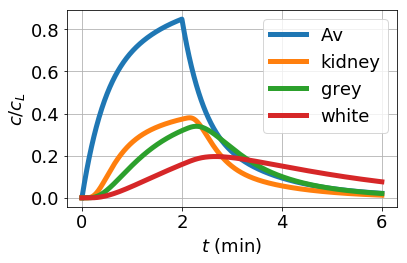

In [54]:
## Plot data
plotPool(plot_pools = ['Av','kidney','grey','white'],conc=True)


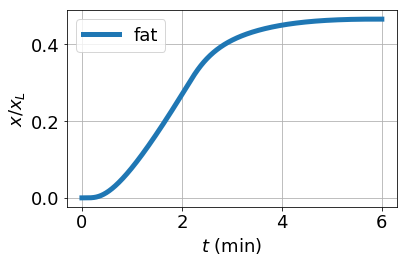

In [55]:
plotPool(plot_pools = ['fat'],conc=False,figname='fat')

# Appendix (Material not used in the paper)

## Pure time delay simulation of symmetric case

### Numerical model
As, at the moment, a bg component with delay is not available, the case with delay is modelled directly using equations suitable for the [ddeint](https://pypi.org/project/ddeint/) Python package.

In [56]:
## Vary the chemostats
def X_chemostat(t,delay):
    x_A1 = 1 + np.heaviside(t-t_0,1)
    x_A2 = 1
    
    return x_A1,x_A2

In [57]:
## Delay-differential equation solver
from ddeint import ddeint

## Model
def model(X, t, delay=1, Q0=1):
    """
    Model for case with non-zero delay
    See the ddeint Python package
    """
    
    ## Extract the state and delayed state components
    x_E1,  x_C1, x_E2, x_C2 = X(t)
    xd_E1,xd_C1,xd_E2,xd_C2 = X(t-delay)
    
    ## Set chemostats
    x_A1,x_A2 = X_chemostat(t,delay)
    
    ## Upstream flows
    f1 = x_E1*x_A1 - x_C1
    F_E1 = (x_E1 - xd_E2)*Q0 
    F_C1 = (x_C1 - xd_C2)*Q0
    
    ## Upstream state derivatives
    dx_E1 = -f1 - F_E1
    dx_C1 =  f1 - F_C1
    
    ## Downstream flows
    f2 = x_C2 - x_E2*x_A2
    F_E2 = (x_E2 - xd_E1)*Q0
    F_C2 = (x_C2 - xd_C1)*Q0
    
    ## Downstrean state derivatives
    dx_E2 =   f2 - F_E2
    dx_C2 =  -f2 - F_C2
    
    ## State derivative
    dX = np.array([dx_E1,dx_C1,dx_E2,dx_C2])
    
    return dX


## Simulation

e0 = 4


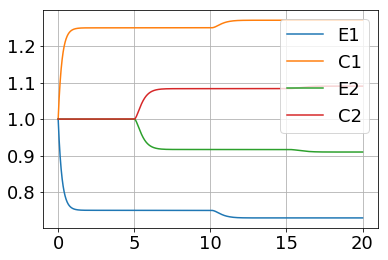

Final states: [0.72916561 1.27083439 0.90972036 1.09027964]
Sum of final states: 4.0


In [58]:
## Main parameters
delay = 5
Q0 = 1

## Initial state (ddeint form)
x0 = (1)*np.array([1,1,1,1])
initial = lambda t: x0

e0 = sum(x0)
print("e0 =",e0)


## Simulate delayed model
XX = ddeint(model, initial, tt, fargs=(delay,Q0,))
XX1 = XX[:,0:4]
e0_sim = sum(XX.T)

## PLot all 8 states
plt.plot(tt, XX)
plt.grid()
Legend = ['E1','C1','E2','C2','E12','C12','E21','C21']
plt.legend(Legend)
plt.show()
print('Final states:', XX[-1,:])
print('Sum of final states:', sum(XX[-1,:]))



### Compare d=0 and d>0

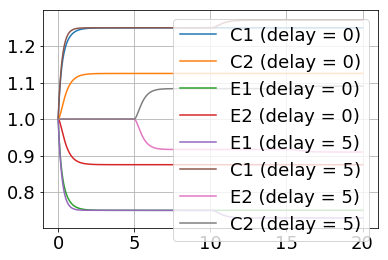

In [59]:
## Plot states
Delay = ' (delay = '+str(delay)+')'
Delay0 = ' (delay = 0)'
Legend = []
for i in range(2,6):
    Legend.append(snd['species'][i]+Delay0)
Legend1 = ['E1','C1','E2','C2']
for Leg in Legend1:
    Legend.append(Leg+Delay)
#Legend = snd['species'][2:6]
plt.plot(tt, XX0, tt, XX1)
plt.grid()

plt.legend(Legend)
plt.show()

[2. 2. 2. ... 2. 2. 2.] 1


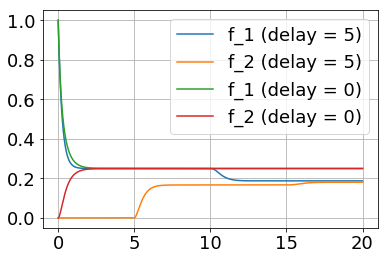

Final flows 0.1874968285755121 0.18055928632873708


In [60]:
## Plot flows
x_E1 = XX1[:,0]
x_C1 = XX1[:,1]
x_E2 = XX1[:,2]
x_C2 = XX1[:,3]
x_A,x_B = X_chemostat(tt,delay)
print(x_A,x_B)
f1 = x_E1*x_A - x_C1
f2 = x_C2 - x_E2*x_B

plt.plot(tt,f1, tt,f2, tt,V0)
plt.grid()

Legend = ['f_1'+Delay, 'f_2'+Delay, 'f_1'+Delay0, 'f_2'+Delay0]
plt.legend(Legend)
plt.show()

print('Final flows',f1[-1],f2[-1])




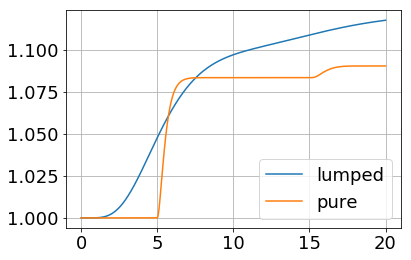

In [61]:
plt.plot(tt,XXPipe[:,1],label='lumped')
plt.plot(tt,XX1[:,3],label='pure')
plt.grid()
plt.legend()

## Numerical computation of chemical/hydraulic interaction (early version)

In [62]:
imp.reload(st)
R = st.R()
print(f'R = {R:4.2f} J/mol/K')
RT = st.RT()
print(f'RT = {RT/1000:4.2f} kJ/mol')

## Concentration ratio rho (example value)
rho = 2
print(f'rho = {rho}')

## Change in chemical potential
dmu = RT*np.log(rho)
print(f'Delta mu = {dmu:4.2f} J/mol')

## Typical haemogblobin conc
c_gl = 150 # g/l - Bionumbers: Hemoglobin concentration in human blood
mass = 64e3 # Daltons=g/mol - https://en.wikipedia.org/wiki/Hemoglobin
c_moll = c_gl/mass # mol/l
c_molm3 = c_moll*1e3 # mol/m^3
# print(f'concentration: {c_molm3} mol/m^3)')
#c = 10 # mol/m3
c = c_molm3 # mol/m3
print(f'c = {c:0.2} mol/m3')
dP = c*dmu
print(f'Delta P = {(dP/1000):0.1f} kPa')

## Typical systolic blood pressure 120mmHg = 16 kPa (https://en.wikipedia.org/wiki/Blood_pressure)
BP = 16e3 # Pa
print(f'Typical blood pressure = {BP/1000} kPa')

R = 8.31 J/mol/K
RT = 2.58 kJ/mol
rho = 2
Delta mu = 1787.44 J/mol
c = 2.3 mol/m3
Delta P = 4.2 kPa
Typical blood pressure = 16.0 kPa
